# Python Text Analysis: Fundamentals, Part 2

In the previous lesson, we learned how to use several packages to preprocess text. However, we never moved beyond the *text representation* - we only manipulated the representation itself. If we want to perform computational analysis on the text, we will need to devise approaches to convert the text into a *numeric representation*.

In this lesson, we'll explore one of the simplest ways to generate a numeric representation from text: the **bag-of-words**. With this numeric representation, we'll build a simple classifier and explore what the classifier tells us. At the heart of the bag-of-words approach lies the hypothesis that the presence and frequency of specific tokens is informative about the semantics and sentiment behind the text.

We'll make heavy use of the `scikit-learn` package to do so, as it provides a nice framework for constructing the numeric representations.

## The Airline Tweets Dataset

We'll work with a dataset consisting of tweets about US airlines. Each sample is a different tweet, which was posted at a specific airline. These tweets may express positive, neutral, or negative "sentiment". Our eventual goal will be to predict the sentiment of the tweet given its text.

The dataset was collected by Crowdflower, which they then made public through Kaggle. We've already downloaded it and placed it in the `data` directory. Note that this dataset, on the whole, is structured nicely and has already undergone some cleaning. However, this is not the norm in real-life data science! We've chosen this dataset so that we can concentrate on learning and understanding the core concepts.

In [1]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/blueraspberry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/blueraspberry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from string import punctuation

%matplotlib inline

In [4]:
# Import pandas
# Use pandas to import tweets
tweets_path = '../data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

## Exploratory Data Analysis

Before we ever do any preprocessing or modeling, we always should do some exploratory data analysis to get a feel for the dataset.

First, let's take a look at the first few rows and all the columns:

In [5]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We have a `tweet_id`, which uniquely identifies each tweet. We also have an `airline_sentiment`, which takes on values of `"positive"`, `"negative"`, or `"neutral"`. There are other columns indicating the author of the tweet, when it was created, the timezone of the user, and others. The main column of interest is the `text` column: these are the tweets. Let's take a look at a few:

In [6]:
for idx in range(5):
    print(tweets['text'].iloc[idx])

@VirginAmerica What @dhepburn said.
@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica I didn't today... Must mean I need to take another trip!
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it


We can already see that some of these tweets very obviously negative sentiment - how can you tell this is the case? 

Let's take a look at which airlines are tweeted about and how many of each in this dataset:

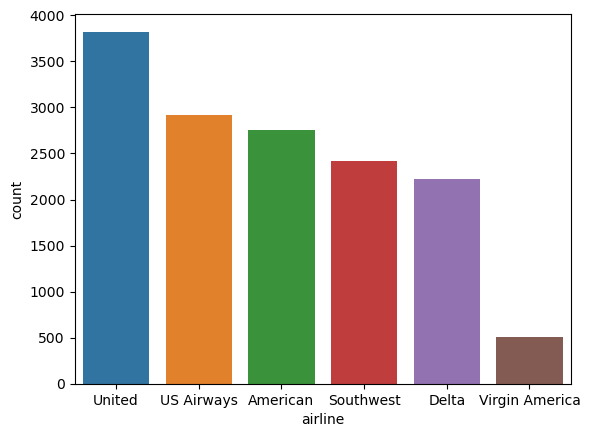

In [7]:
airlines = tweets['airline']
sns.countplot(x=airlines, order=airlines.value_counts().index)
plt.show()

---

### Challenge 1: Getting to Know the Data

Use `pandas` to find out the following about the airline tweets:

* How many tweets are in the dataset?
* How many tweets are positive, neutral, and negative?
* What *proportion* of tweets are positive, neutral, and negative?
* Make a bar plot showing the proportion of tweet sentiments.

If you have time, try the following:

* How much time separates the earliest and latest tweets?
* What gets more retweets: positive, negative, or neutral tweets?
* Identify the airline whose tweets have the highest proportion of negative sentiment.

---

In [8]:
# How many tweets are in the dataset?
tweets.shape[0]

14640

In [9]:
# How many tweets are positive, neutral, and negative?
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [10]:
# What *proportion* of tweets are positive, neutral, and negative?
tweets['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

<Axes: xlabel='airline_sentiment', ylabel='count'>

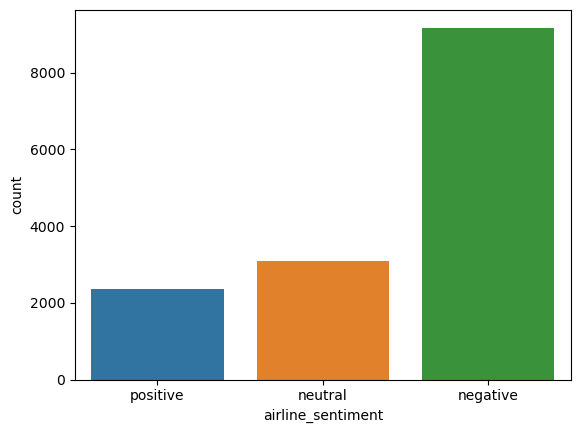

In [11]:
# Make a bar plot showing the proportion of tweet sentiments
sns.countplot(x=tweets['airline_sentiment'], order=['positive', 'neutral', 'negative'])

In [12]:
# How much time separates the earliest and latest tweets?
sorted_by_time = pd.to_datetime(tweets['tweet_created'].sort_values())
sorted_by_time.iloc[-1] - sorted_by_time.iloc[0]

Timedelta('7 days 12:17:32')

In [13]:
# What gets more retweets: positive, negative, or neutral tweets?
tweets.groupby('airline_sentiment')['retweet_count'].mean()

airline_sentiment
negative    0.093375
neutral     0.060987
positive    0.069403
Name: retweet_count, dtype: float64

In [14]:
# Which airline receives the highest proportion of negative tweets?
proportions = tweets.groupby(['airline', 'airline_sentiment']).size() / tweets.groupby('airline').size()
proportions.unstack().sort_values('negative')

airline_sentiment,negative,neutral,positive
airline,,,
Virgin America,0.359127,0.339286,0.301587
Delta,0.429793,0.325383,0.244824
Southwest,0.490083,0.274380,0.235537
United,0.688906,0.182365,0.128728
American,0.710402,0.167814,0.121783
US Airways,0.776862,0.130793,0.092345


## Preprocessing

We spent much of the last workshop learning how to preprocess the data. Let's apply what we learned to this dataset. Looking at some of the tweets above, we can see that while they are in pretty good shape, we can do some additional processing on them.

In our pipeline, we'll omit the tokenization process, since we will perform it in a later step. Instead, we'll add a couple new preprocessing steps now that we are working with social media data. Specifically, we'll replace all hashtags with a "HASHTAG" token, and we'll replace all users (denoted by the "@" symbol) with a "USER" token. 

---

### Challenge 2: Creating a Preprocessing Pipeline for Social Media Data

Write a function called `preprocess()` that performs the following on a text input:

* Lowercase text.
* Replace all URLs with the token "URL".
* Replace all numbers with the token "DIGIT".
* Replace hashtags with the token "HASHTAG".
* Replace all users with the token "USER".
* Remove blankspaces.

We have provided regex patterns for each of the replacement steps in the following cells.

Run your `preprocess()` function on `example_tweet` (two cells below), and when you think you have it working, apply it to the entire `text` column in the tweets DataFrame.

---

In [15]:
# Useful regex patterns
url_pattern = r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
digit_pattern = '\d+'
hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
user_pattern = r'@(\w+)'

In [16]:
# Apply your function to the following example
example_tweet = "lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo"

In [17]:
def preprocess(text):
    # YOUR CODE HERE
    """Preprocesses a string."""
    # Lowercase
    text = text.lower()
    # Replace URLs
    url_pattern = r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
    url_repl = ' URL '
    text = re.sub(url_pattern, url_repl, text)
    # Replace digits
    digit_pattern = '\d+'
    digit_repl = ' DIGIT '
    text = re.sub(digit_pattern, digit_repl, text)
    # Replace hashtags
    hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
    hashtag_repl = ' HASHTAG '
    text = re.sub(hashtag_pattern, hashtag_repl, text)
    # Replace users
    user_pattern = r'@(\w+)'
    user_repl = ' USER '
    text = re.sub(user_pattern, user_repl, text)
    # Remove blank spaces
    blankspace_pattern = r'\s+'
    blankspace_repl = ' '
    text = re.sub(blankspace_pattern, blankspace_repl, text).strip()
    return text

In [18]:
# Test on example tweet
preprocess(example_tweet)

'lol USER and USER are like soo DIGIT HASHTAG HASHTAG saw it on URL HASHTAG'

In [19]:
# Apply to text column to create a new column
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0                                 USER what USER said.
1    USER plus you've added commercials to the expe...
2    USER i didn't today... must mean i need to tak...
3    USER it's really aggressive to blast obnoxious...
4        USER and it's a really big bad thing about it
Name: text_processed, dtype: object

Preprocessing is complete - time for the bag-of-words!

## The Bag-of-Words Representation

The fundamental principle behind bag-of-words is to encode the corpus in terms of word frequencies. Consider the case of sentiment: we know sentiment is conveyed more strongly by specific words. For example, if a tweet contains the word "happy", it likely conveys positive sentiment (but not always - someone might say they're "not happy" - the opposite sentiment!). Furthermore, when those words come up more often, they'll probably more strongly convey the sentiment.

In a bag-of-words, we taken some text, tokenize it, and then tabulate the frequencies of each token. The numerical representation of the text, then, is a vector indicating the frequencies of each token for that text.

For example, if we're considering a movie review as follows: 

![bow](../images/bow.png)

We take each token from the review, "toss it in a bag", and count up the frequencies of each word. The numerical representation, then, is the vector on the right: the number of appearances of each token. The "bag" here denotes that we are not modeling structure within the text - only the frequencies of the words.

### Document Term Matrix

In most text corpora, we will have many samples or *documents*. For example, in the airline tweets dataset, we have many tweets. Each tweet stands on its own as a unique sample: they can each be thought of as a unique document in the entire *corpus*. Since they are all related to each other, many tokens might be shared across tweets. So, when creating the bag-of-words model, we can tokenize across all documents, forming a *vocabulary*. Then, we can represent a single document by which of the tokens in the vocabulary are represented, and their frequency within the document.

If the vocabulary has $V$ tokens, then each document will be encoded in a $V$-dimensional vector. If there are $D$ documents, the entire dataset can be represented in a $D \times V$ matrix, where each row corresponds to the document, and each column corresponds to the token (or "term"). This $D \times V$ matrix is a **document term matrix** (DTM).

Let's consider a simple example. Suppose we have the "documents":

```
["You are at a workshop. Are you ready?",
 "Welcome to Berkeley!",
 "I am teaching a workshop."]
```

The unique (word) tokens in this "corpus", in alphabetical order, are:

```
[a, am, are, at, berkeley, i, ready, teaching, to, welcome, workshop, you]
```

The DTM can be formed by going through each document, ticking off the frequency of each token in each document, and plugging this number into the matrix:

$$
\begin{array}{c|cccccccccccc}
 & \text{a} & \text{am} & \text{are} & \text{at} & \text{berkeley} & \text{i} & \text{ready} & \text{teaching} & \text{to} & \text{welcome} & \text{workshop} & \text{you} \\\hline
\text{Document 1} & 1 & 0 & 2 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 1 \\
\text{Document 2} & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 1 & 0 & 0 \\
\text{Document 3} & 1 & 1 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 0 & 1 & 0 \\
\end{array}
$$

The numerical representation for each document is a row in the matrix. For example, Document 1 has numerical representation $[1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1]$.

To create a DTM, we will use the `CountVectorizer` from the package `sklearn`, a heavily used machine learning package.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

If you're not familiar with `sklearn`, here is the general workflow:

1. We first create a `CountVectorizer` object, and choose specific settings for how we'll go about creating the DTM. Check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to see what options are available.
2. Then, we "fit" this `CountVectorizer` object to the data. In this context, "fitting" consists of establishing a vocabulary of tokens from the documents in your dataset.
3. Finally, we "transform" the data according to the "fitted" `CountVectorizer` object. This means taking our text data and transforming it into a DTM according to the vocabulary established by the "fitting" step.
4. You can do steps 2 and 3 in one fell swoop using a `fit_transform` function.

Let's start by creating a `CountVectorizer` with the default settings:

In [21]:
vectorizer = CountVectorizer()

Next, we'll fit *and* transform the airline tweets data. What does the documentation say about this function? 

We need to pass in all the tweets. What is returned?

In [22]:
counts = vectorizer.fit_transform(tweets['text_processed'])
counts

<14640x9913 sparse matrix of type '<class 'numpy.int64'>'
	with 230849 stored elements in Compressed Sparse Row format>

It's not *quite* a `numpy` array. Instead, it's a `numpy` array stored in "Compressed Sparse Format". This format saves a lot of memory, but it is difficult to look at for a human. To illustrate the techniques in this lesson we will first uncompress this matrix. For larger datasets, however, you'll want to avoid this, as there are performance benefits to using CSF.

Converting to a normal `numpy` array is easy: we use a built-in `todense()` function, and pass this into the `np.array()` function:

In [24]:
# Do not run if you have limited memory - this includes DataHub and Binder
np.array(counts.todense())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

There are a lot of zeros here! This makes sense: there are probably a lot of tokens in the vocabulary, and each tweet likely only has a few of the tokens.

It would be good to know which column refers to which tokens. Let's create a `pandas` DataFrame which has this information. First, we'll need to get the names of each token - how can we do this? Hint: always read the documentation!

In [25]:
# Extract tokens
tokens = vectorizer.get_feature_names_out()
# Run this instead if you scikit-learn version is a bit older
# tokens = vectorizer.get_feature_names()
# Create DTM
dtm = pd.DataFrame(data=counts.todense(),
                   index=tweets.index,
                   columns=tokens)
# Look at DTM
print(dtm.shape)
dtm.head()

(14640, 9913)


,_exact_,_wtvd,aa,aaaand,aadavantage,aadv,aadvantage,aal,aaron,ab,...,zero,zig,zip,zippers,zone,zones,zoom,zukes,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


What can we do with the DTM? For one, we can see the most frequent tokens:

In [26]:
dtm.sum().sort_values(ascending=False).head(10)

user      16500
to         8653
digit      8427
the        6063
you        4401
for        4001
flight     3935
on         3815
and        3733
my         3288
dtype: int64

---

### Challenge 3: DTM Data Analysis

* Print out the most infrequent words rather than the most frequent words. If you're not sure how, check the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)!
* Print the average number of times each word is used in a tweet.
* Which non-hashtag, non-digit token appears the most in any given tweet? How many times does it appear? What is the original tweet?

---

In [27]:
# YOUR CODE HERE
# Print out the most infrequent words rather than the most frequent words.
dtm.sum().sort_values(ascending=True).head(20)

_exact_       1
minus         1
minssss       1
minors        1
minonhold     1
minimal       1
mini          1
minflight     1
mines         1
mindset       1
miracles      1
mimosa        1
milestone     1
milesaaver    1
mild          1
milageplus    1
milage        1
mikes         1
mikehertz     1
mighty        1
dtype: int64

In [28]:
# Print the average number of times each word is used in a tweet.
dtm.mean().sort_values(ascending=False).head(20)

user       1.127049
to         0.591052
digit      0.575615
the        0.414139
you        0.300615
for        0.273292
flight     0.268784
on         0.260587
and        0.254986
my         0.224590
hashtag    0.221516
is         0.193374
in         0.176776
it         0.164754
of         0.145014
me         0.131489
your       0.119057
that       0.118579
can        0.113183
have       0.112432
dtype: float64

In [29]:
# Which non-hashtag, non-digit token appears the most in any given tweet? How many times does it appear? What is the original tweet?
counts = pd.DataFrame()
counts['token'] = dtm.idxmax(axis=1)
counts['number'] = dtm.max(axis=1)
counts[(counts['token'] != 'digit')
       & (counts['token'] != 'hashtag')
       & (counts['token'] != 'user')].sort_values(
    'number',
    ascending=False).head(10)

,token,number
3915,lt,6
1214,worst,6
10173,to,5
3412,to,5
792,to,5
6469,to,5
13715,to,5
10614,the,5
14030,to,5
10599,to,5


In [30]:
# What is the original tweet?
# Examine index 3915: "It"
tweets.iloc[3915]['text']

'@united &lt;&lt;&lt;&lt;&lt;&lt;-------- do not reply to emails?'

In [31]:
# What is the original tweet?
# Examine index 1214: "worst"
tweets.iloc[1214]['text']

"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!"

### Customizing the `CountVectorizer`

Recall the documentation on the `CountVectorizer` object: there are many options here on how you can customize the procedure of generating the vocabulary. Let's highlight some of these values:

* `lowercase`: If `True`, it will lowercase all text. This was one of our preprocessing steps from before!
* `stop_words`: You can choose or provide a list of stop-words. The `"english"` option is a built-in stop-word list, but you could provide another (e.g., the stop-word list provided by `nltk`).
* `min_df` or `max_df`: The **document frequency** is the fraction of documents that a token appears in. If this value is high (close to 1), a token appears in most documents. If it's low (close to 0), it appears in very few documents. You might want to remove very rare tokens (they could be typos or gibberish) and you might want to remove very common tokens (these could be uninformative words that aren't stop words). These arguments allow you to specify a range of desired document frequencies. They can either be counts or fractions.

In [32]:
# Create the vectorizer
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    min_df=2,
    max_df=0.95)
# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_processed'])
tokens = vectorizer.get_feature_names_out()
# Run this instead if you scikit-learn version is a bit older
# tokens = vectorizer.get_feature_names()
# Create dataframe
dtm = pd.DataFrame(data=counts.todense(),
                   index=tweets.index,
                   columns=tokens)
print(dtm.shape)
dtm.head()

(14640, 5152)


,aa,aadv,aadvantage,aal,abandoned,abc,abi,abilities,ability,able,...,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


How did the number of tokens change with our new parameter settings?

---

### Challenge 4: Customizing the Vectorizer with `nltk` inputs

If you look at the `CountVectorizer` documentation, you'll see that it can actually accept a custom `tokenizer` and `stop_words` list. 

Using what you learned in the previous workshop, create a `CountVectorizer` that utilizes the `nltk` word tokenizer and stop word list. How does the resulting DTM look different?

---

In [33]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [34]:
# YOUR CODE HERE
# Find stop words
stop_words = stopwords.words('english')
# Create the vectorizer
vectorizer = CountVectorizer(
    lowercase=True,
    tokenizer=word_tokenize,
    stop_words=stop_words,
    min_df=2,
    max_df=0.95)
# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_processed'])
tokens = vectorizer.get_feature_names_out()
# Make DTM
dtm = pd.DataFrame(data=counts.todense(),
                   index=tweets.index,
                   columns=tokens)
print(dtm.shape)
dtm.head()

/Users/blueraspberry/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/blueraspberry/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


(14640, 5518)


,!,#,$,%,&,','','bluemanity,'blumanity,'customer,...,😢,😤,😥,😩,😩😩😩,😭,😭😭,😳,🙏,🙏🙏🙏✌️✌️✌️🙏🙏🙏
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Term Frequency-Inverse Document Frequency Scores (TF-IDF)

So far, we're relying on word frequencies to give us information about a document. This assumes if a word appears more often in a document, it's more informative. However, this may not always be the case. For example, we already remove stop-words because they are not informative, despite the fact that they appear many times in a document. In the airline tweets, the word `flight` appears many times across the corpus, but is also not that informative, because it appears in many documents. Since we're looking at airline tweets, we shouldn't be surprised to see the word `flight`!

To remedy this, we use a weighting scheme called **tf-idf (term frequency-inverse document frequency)**. The big idea behind tf-idf is to weight words not just by their frequency *within* a document, but by their frequency in one document *relative* to the remaining documents. Words that are frequent, but also used in every single document, will not be that informative. We want to identify words that are unevenly distributed across the corpus: these are the words most likely to be informative in a particular document.

So, when we construct the DTM, we will be assigning each value a **tf-idf score**. Specifically, term $t$ in document $d$ is assigned tf-idf score as follows:

$$
\text{tf-idf}(d, t) = \text{tf}(d, t) \times \text{idf}(t)
$$

where $\text{tf}(d, t)$ is the term-frequency of term $t$ in document $d$ and $\text{idf}(t)$ is the inverse-document frequency of term $t$. 

When we used the `CountVectorizer` above, we only considered **term frequency**: if a term appeared more times in a document, it was given a higher value in the DTM. Now, we are scaling the term frequency by the **inverse document frequency**: if a term appears in many documents, we give it a lower weight, since it is less "surprising". 

We're not done yet: we still need to define the actual functions. In the `CountVectorizer`, the `tf(d, t)` function was simply $n_{d,t}$, or the number of times term $t$ appeared in document $d$. However, we can use other functions. In this case, we'll use:

$$
\text{tf}(d, t) = \frac{n_{d,t}}{N_d}
$$

where $N_d$ is the number of terms in document $d$. All we're doing here is normalizing the term frequency used in the `CountVectorizer`. Next, the inverse document frequency can be calculated as

$$
\text{idf}(t) = 1 + \log\left(\frac{D}{D_t}\right)
$$

where $D$ is the total number of documents, and $D_t$ is the number of documents containing term $t$. If every document contains term $t$, then $\text{idf}(t) = 1$, and no scaling will happen. If very few documents contain term $t$, then $\text{idf}(t)$ will be very large, and the term frequency will be scaled up. In practice, the inverse document frequency is computed as 

$$
\text{idf}(t) = 1 + \log\left(\frac{1 + D}{1 + D_t}\right)
$$

to prevent any issues with zero occurrences.

We can also create a tf-idf DTM using `sklearn`. We'll use a `TfidfVectorizer` this time:

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
vectorizer = TfidfVectorizer()
dtm = vectorizer.fit_transform(tweets['text_processed'])
dtm

<14640x9913 sparse matrix of type '<class 'numpy.float64'>'
	with 230849 stored elements in Compressed Sparse Row format>

In [37]:
tfidf = pd.DataFrame(dtm.todense(),
                     columns=vectorizer.get_feature_names_out(),
                     index=tweets.index)
# Run this if your scikit-learn version is older
#tfidf = pd.DataFrame(dtm.todense(),
#                     columns=vectorizer.get_feature_names(),
#                     index=tweets.index)
tfidf.head()

,_exact_,_wtvd,aa,aaaand,aadavantage,aadv,aadvantage,aal,aaron,ab,...,zero,zig,zip,zippers,zone,zones,zoom,zukes,zurich,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's look at the 20 words with the highest tf-idf weights:

In [38]:
tfidf.max().sort_values(ascending=True).head(20)

whatsoever    0.245656
rly           0.246627
aftr          0.248886
fnd           0.248886
hstg          0.248886
med           0.248886
bng           0.248886
cnceld        0.248886
dread         0.250462
fantasy       0.255245
rapidly       0.255245
dpted         0.257093
connex        0.261642
dkyde         0.263007
lick          0.267418
shoulda       0.268080
miscnx        0.269171
runners       0.269171
awrd          0.269371
savr          0.269371
dtype: float64

## Supervised Learning: Sentiment Classification

Now that we have a numerical representation of the text, we'd like to *do* something with it. A common task is supervised learning: using the numerical representation to predict some kind of label about the text. Text classification can consist of many types of analysis, such as:

* Sentiment analysis
* Genre classification
* Language identification
* Authorship attribution
* Spam detection
* Document relevancy

and many others. How exactly do we go about doing this?

Let's consider a toy example:

```"This was the best service! Would love to come again!"```

This is very clearly expressing positive sentiment. But how did we make that judgement?

* The review claims the service is the "best". This is pretty positive.
* The reviewer says they would "love" to come again. This is also positive.

Specific key words (tokens) were predictive of the sentiment. If someone says something was the "best", it's a good sign there's positive sentiment in the text. The semantic meaning of these words helps convey sentiment. 

This is how we can proceed with classification. We'll construct a DTM from the text data, and use that to predict the labels using a machine learning model.

### Predicting Sentiment with Logistic Regression

We're going to use a logistic regression model to predict the labels. If you're not familiar with this model, or the basics of machine learning, we recommend taking the Python Machine Learning workshop offered at the D-Lab. For now, we'll review some basics.

The DTM is a $D\times T$ matrix, where $D$ is the number of documents, and $T$ is the number of terms. We can think of the $T$ terms as the "features": these values are what we'll use to predict the sentiment. The $D$ documents represent samples: we'll use the patterns across these samples to learn a relationship between the feature and the outcome.

In logistic regression, we are learning a **linear model** represented by specific parameters, which we'll call $\beta_i$. For features $x_i$ (this is a row in the DTM), we construct a **logit**:

$$
L = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_T x_T
$$

and obtain a probability $p$ by passing this logit through the **sigmoid function**, which maps any value onto the range $[0, 1]$:

$$
p = \text{sigmoid}(L) = \frac{1}{1 + \exp(-L)}
$$

We can quite literally think of $p$ as a probability that the sample falls in one of the two classes. If, say, $p>0.5$, we call the sample positive sentiment; otherwise, it's negative sentiment.

So, to summarize: we take each sample, which consists of features $x = (x_1, x_2, \ldots, x_T)$, multiply them by $\beta_i$ values, and add them up. Pass them through a sigmoid, and get a probability. The key question is: how do we know what $\beta_i$ values to use? We won't discuss thus details here, but an optimization algorithm will learn the best values given the data. 

Let's train a model! We're going to use `sklearn` to do this:

In [39]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [40]:
# Did you kernel die from memory issues? 
# Here's a handy cell to get everything set up from here.
# You can restart your kernel and just start from this point. 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from string import punctuation

%matplotlib inline

# Load tweets
tweets_path = '../data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

def preprocess(text):
    """Preprocesses a string."""
    # Lowercase
    text = text.lower()
    # Replace URLs
    url_pattern = r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
    url_repl = ' URL '
    text = re.sub(url_pattern, url_repl, text)
    # Replace digits
    digit_pattern = '\d+'
    digit_repl = ' DIGIT '
    text = re.sub(digit_pattern, digit_repl, text)
    # Replace hashtags
    hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
    hashtag_repl = ' HASHTAG '
    text = re.sub(hashtag_pattern, hashtag_repl, text)
    # Replace users
    user_pattern = r'@(\w+)'
    user_repl = ' USER '
    text = re.sub(user_pattern, user_repl, text)
    # Remove blank spaces
    blankspace_pattern = r'\s+'
    blankspace_repl = ' '
    text = re.sub(blankspace_pattern, blankspace_repl, text).strip()
    return text

tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
example_tweet = "lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo"

To understand the theoretical gist of our classification task, let's first focus on a binary 'positive vs negative' classifier. We are going to do so by restricting the analysis to the non-neutral tweets. So, we'll first partition the dataframe:

In [41]:
tweets_binary = tweets[tweets['airline_sentiment'] != 'neutral']
tweets_binary.shape

(11541, 16)

Next, we're going to apply a tf-idf vectorizer to the data. We're going to make use of the `max_features` argument to restrict the number of tokens our model has to consider:

In [42]:
vectorizer = TfidfVectorizer(max_features=5000)
dtm = vectorizer.fit_transform(tweets_binary['text_processed'])
X = np.asarray(dtm.todense())
print(X.shape)

(11541, 5000)


Now, we need to get the labels for each of the 11,541 tweets. We can do this by simply extracting the `airline_sentiment` column - `sklearn` is smart enough to handle the details later. Let's also check out the distribution of the labels, to get a sense for a good baseline:

In [43]:
y = tweets_binary['airline_sentiment']
print(y.value_counts())
print(y.value_counts(normalize=True))

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64
negative    0.795252
positive    0.204748
Name: airline_sentiment, dtype: float64


Machine learning fundamentally requires that we learn the $\beta_i$ values from a **training set**, and then evaluate the performance on a separately held **test set**. This ensures that we actually develop an algorithm that can **generalize**. We'll use the `train_test_split` function from `sklearn` to separate our data into two sets:

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In order to streamline the training process, we've written a `fit_logistic_regression` function you can use to easily train a model given the data inputs:

In [45]:
def fit_logistic_regression(X, y):
    """Fits a logistic regression model to provided data."""
    model = LogisticRegressionCV(
        Cs=10,
        penalty='l1',
        cv=3,
        solver='liblinear',
        refit=True).fit(X, y)
    return model

We'll fit the model, and see how it performs on both the training and test sets:

In [46]:
# Fit the logistic regression model
model = fit_logistic_regression(X_train, y_train)

In [47]:
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 0.9542894280762565
Test accuracy: 0.9246427024686011


The model got ~95% accuracy on the training set, and ~92% on the test set - that's pretty good! The similarity between the two performances is also a good sign - it means we were able to generalize pretty well.

### Validating Model Performance on New Tweets

Now that we have a trained model, there's nothing stopping us from using it on new data! The `model` object comes equipped with a `predict` function that we can use to evaluate on new text samples:

In [48]:
# Some new tweets
new_tweets = [example_tweet,
              'omg I am never flying on United again',
              'I love @VirginAmerica so much #friendlystaff',
              'food on Air France is great!']
# First, we need to preprocess them
new_tweets_processed = [preprocess(tweet) for tweet in new_tweets]
# Next, we need to vectorize them
X_new = np.asarray(vectorizer.transform(new_tweets_processed).todense())

In [49]:
# Run predictions
model.predict(X_new)

array(['positive', 'negative', 'positive', 'positive'], dtype=object)

In [50]:
# Get probabilities
model.predict_proba(X_new)

array([[4.27445537e-01, 5.72554463e-01],
       [8.91905961e-01, 1.08094039e-01],
       [6.10067183e-04, 9.99389933e-01],
       [1.78504108e-01, 8.21495892e-01]])

Those predictions look pretty good! Feel free to give the model a try on other tweets you write.

### Interpreting the Model Coefficients

The nice thing about logistic regression is that it is **interpretable**. Take a look at the logit again:

$$
L = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_T x_T
$$

If $L$ is very positive, the sigmoid will make sure that the probability $p$ is close to 1 (positive sentiment). If $L$ is very negative, the sigmoid will make sure that the probability $p$ is close to 0 (negative sentiment). So, by looking at the coefficients $\beta_i$, we can see how each feature (token) impacts the eventual prediction. If $\beta_i >0$, then the presence of that feature implies positive sentiment, according to the model. If  $\beta_i < 0$, then the presence of that feature implies negative sentiment, according to the model.

So, let's take a look at the fitted coefficients to see if what we see makes sense! We can access them using the `coef_` member, and we can match each coefficient to the tokens from the vectorizer:

In [51]:
coefs = model.coef_.ravel()
tokens = vectorizer.get_feature_names_out()
importance = pd.DataFrame()
importance['token'] = tokens
importance['coefs'] = coefs

In [52]:
importance.head()

,token,coefs
0,aa,-1.45732
1,aadv,0.00000
2,aadvantage,0.00000
3,aal,0.00000
4,abandoned,0.00000


In [53]:
importance.sort_values('coefs')

,token,coefs
4888,worst,-12.366297
2797,not,-9.585467
3771,rude,-9.388493
2803,nothing,-8.918637
2014,hours,-8.836287
...,...,...
4884,worries,10.723278
2310,kudos,11.675550
4857,wonderful,11.918034
4378,thanks,14.263034


This makes sense! Tokens like "worst", "not", and "rude" imply negative sentiment, while tokens like "thanks", "kudos", "awesome" imply positive sentiment. Interestingly, the token "worries" implies positive sentiment - what does this tell you about how people typically use this token in their tweets?

---

### Challenge 5

Try developing a **multinomial logistic regression** model, to predict positive, negative, and neutral labels. We've provided you a fitter function below, but it's up to you to create new labels, train-test splits, and perform the fitting and evaluation!

---

In [54]:
def fit_multinomial_logistic_regression(X, y):
    """Fits a logistic regression model to provided data."""
    model = LogisticRegressionCV(
        multi_class='multinomial',
        Cs=10,
        penalty='l1',
        cv=3,
        solver='saga',
        refit=True).fit(X, y)
    return model

In [55]:
# YOUR CODE HERE
vectorizer = TfidfVectorizer(max_features=5000)
dtm = vectorizer.fit_transform(tweets['text_processed'])
X = np.asarray(dtm.todense())
y = tweets['airline_sentiment']
print(X.shape)

(14640, 5000)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [59]:
model = fit_multinomial_logistic_regression(X_train, y_train)

/Users/blueraspberry/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/blueraspberry/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/blueraspberry/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

In [60]:
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 0.5664275956284153
Test accuracy: 0.5621584699453552


---

### Challenge 6

Create a new fitter function that uses a `RandomForestClassifier`. How is the performance? Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for more details.

---

In [61]:
def fit_random_forest(X, y):
    """Fits a random forest model to provided data."""
    # YOUR CODE HERE
    model = RandomForestClassifier(n_estimators=50).fit(X, y)
    return model

In [62]:
tweets_binary = tweets[tweets['airline_sentiment'] != 'neutral']
vectorizer = TfidfVectorizer(max_features=5000)
dtm = vectorizer.fit_transform(tweets_binary['text_processed'])
X = np.asarray(dtm.todense())
y = tweets_binary['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [63]:
model = fit_random_forest(X_train, y_train)

In [64]:
# Testing performance
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 0.9994584055459272
Test accuracy: 0.8744045041143352
